# Algorithme génétique du Travelling salesman problem

## Données

In [11]:
data <- read.csv(file="cities.csv", header=TRUE, sep=",")
cities <- colnames(data)
data

Brighton,Bristol,Cambridge,Glasgow,Liverpool,London,Manchester,Oxford
0,172,145,607,329,72,312,120
182,0,192,494,209,158,216,92
145,192,0,490,237,75,205,100
607,494,490,0,286,545,296,489
329,209,237,286,0,421,49,208
72,158,75,545,421,0,249,75
312,216,205,296,49,249,0,194
120,92,100,489,208,75,194,0


## Paramètres

In [12]:
population_size <- 10
elitisme_rate <- 0.005 
mutation_rate <- 0.3
ch_length <- length(cities)
crossover_rate <- 0.5
crossover_count <- round(ch_length * crossover_rate)
max_generation <- 200

## Fitness

In [13]:
fitness <- function(ch) {
    ch <- c(ch, ch[1])
    total <- 0
    
    for(i in 1:(ch_length - 1)){
        from <- ch[i]
        to <- ch[i + 1]        
        total <- total + as.numeric(data[from,to])
    }
    return(1 / total)
}

## Mutation

<pre>
[8, <b>6</b>, 2, 7, 1, <b>4</b>, 3, 5] --> [8, <b>4</b>, 2, 7, 1, <b>6</b>, 3, 5]
</pre>
``

In [14]:
switch_elem <- function(x,i,j) {x[c(i,j)] <- x[c(j,i)]; x} 
mutate <- function(ch) {
    if(runif(1, 0, 1) >= mutation_rate){
        indices <- sample(1:ch_length, 2)
        ch <- switch_elem(ch, indices[1], indices[2])
    }
    return(ch)
}

## Crossover 

Order 1 crossover

<img src="https://www.researchgate.net/profile/Shuihua_Wang2/publication/282998951/figure/fig4/AS:433588496801795@1480386961920/An-example-of-order-crossover.png" width="500" />

In [15]:
crossover <- function(parent1, parent2){
    generate_child <- function(p1, p2){
        i <- ceiling(runif(1, 0, ch_length-crossover_count+1))    
        marked <- p1[i:(i+crossover_count-1)]

        child <- p2 [! p2 %in% marked] 

        pre_parent <- child[1:i-1]    

        post_parent <- child[i+crossover_count-1:length(child)]
        post_parent <- post_parent[!is.na(post_parent)]

        return(c(pre_parent, marked, post_parent))    
    }
    
    return(
        matrix(
            c(
                generate_child(parent1, parent2), 
                generate_child(parent2, parent1)
            ), 
            nrow = ch_length, 
            ncol = 2
        ))    
}

## Initialisation

In [16]:
generate_population <- function(){
    return(replicate(population_size, sample(1:ch_length, ch_length)))
}

## Selection

Roulette selection

<img src="http://www.edc.ncl.ac.uk/assets/hilite_graphics/rhjan07g02.png" alt="drawing" width="300"/>


In [17]:
selection <- function(population, pop_fitness){    
    proportions <- pop_fitness / sum(pop_fitness)
    
    summed_proportions <- integer(length(proportions))    
    for(i in 1:length(proportions)){
        summed_proportions[i] <- sum(proportions[1:i])
    }
    
    rand <- runif(1, 0, 1)
    for(i in 1:length(summed_proportions)){
        if(rand <= summed_proportions[i]){
            return(population[,i])
        }
    }
}

## Élitisme

In [18]:
elitism <- function(population, pop_fitness){
    index <- ceiling(elitisme_rate * length(pop_fitness))
    elite_min_fitness <- sort(pop_fitness, decreasing = TRUE)[index]
    return(population[,which(pop_fitness >= elite_min_fitness)])
}

## Évolution

In [19]:
historical_fitness = matrix(numeric(0),ncol=3)
population <- generate_population()

for(generation in 1:max_generation){
    pop_fitness <- apply(population, 2 ,fitness)    
    elites <- elitism(population, pop_fitness)    
    crossed_mutated <- matrix(,8,0)   
    max_cross <- ((population_size-ceiling(elitisme_rate * length(pop_fitness))) / 2)
    for(cross in 1:max_cross){   
        parent1 <- selection(population, pop_fitness)
        parent2 <- selection(population, pop_fitness)        
        while(all(parent1 == parent2)){
            parent2 <- selection(population, pop_fitness)
        }
        
        # crossover
        childs <- crossover(parent1, parent2)
        # mutation
        childs <- apply(childs, 2, mutate)  
        crossed_mutated <- cbind(crossed_mutated, childs)        
    }
    
    population = cbind(elites, crossed_mutated)   
    historical_fitness = rbind(historical_fitness, 
                               c(max(pop_fitness), 
                                 mean(pop_fitness), 
                                 min(pop_fitness))
                              )
}

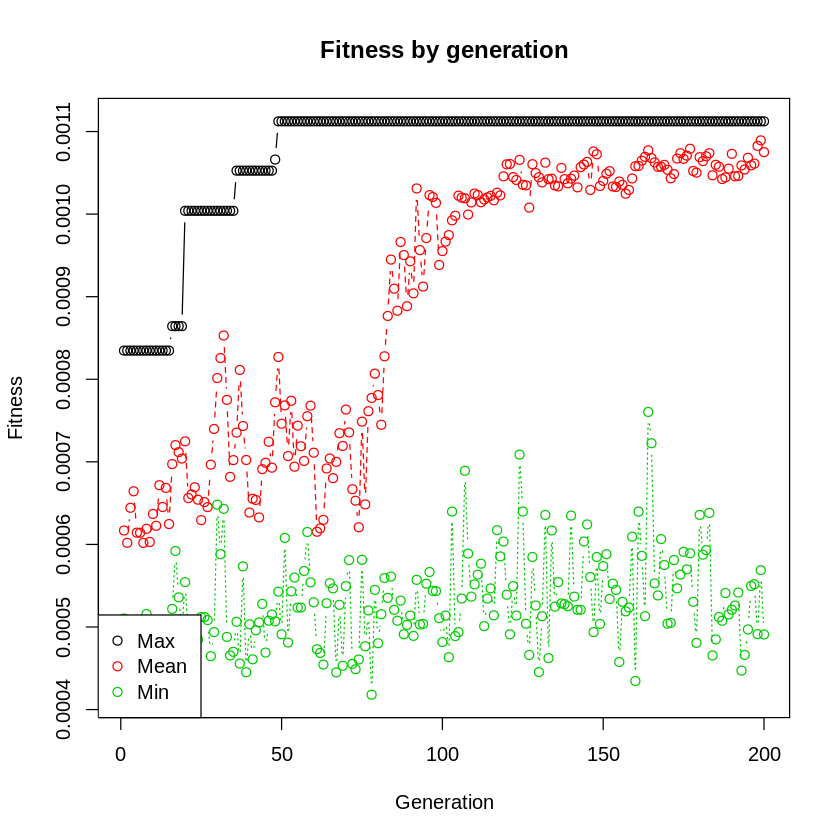

In [20]:
matplot(historical_fitness, 
        type = c("b"), 
        pch=1, 
        col = 1:3, 
        xlab="Generation",
        ylab="Fitness",
        main="Fitness by generation") 

legend("bottomleft", legend = c("Max", "Mean", "Min"), col=1:3, pch=1) 